# Preamble

## Imports

In [3]:
##ALL OF THE IMPORTS AND SUCH

import os
from concurrent.futures import ProcessPoolExecutor, as_completed

from LightPipes import *
from LightPipes import Field

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import math
import cmath
from numpy import genfromtxt
import colorcet as cc
import random
import aotools
import itertools
from tqdm import tqdm as progress
import random

import numpy as np
from numpy.linalg import eig,eigh
import scipy as sp

import pylab as pl

plt.style.use('dark_background')

## Colours

In [4]:
#Generate Colormap Intensity
cmap = np.zeros([256, 4])
cmap[:, 3] = np.linspace(0, 1, 256)
cmap[:, 0]= np.linspace(0, 0, 256)
cmap[:, 1]= np.linspace(0, 0, 256)
cmap[:, 2]= np.linspace(0, 0, 256)
#Intensity colours
imap = matplotlib.colors.ListedColormap(cmap)
#Phase colours
pmap= cc.m_CET_C6

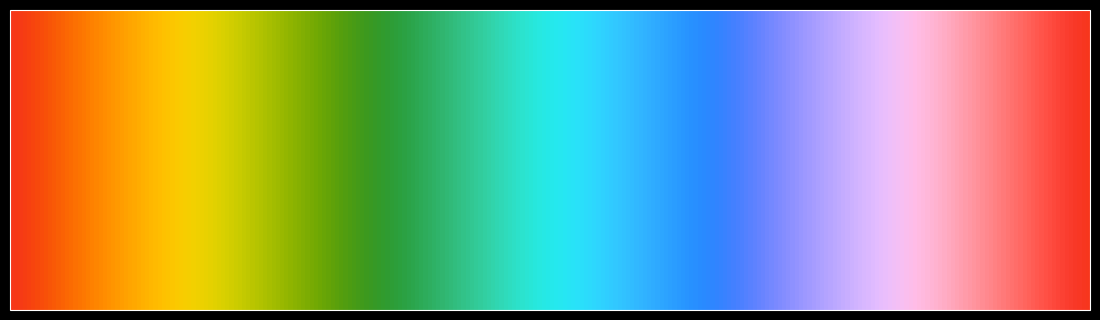

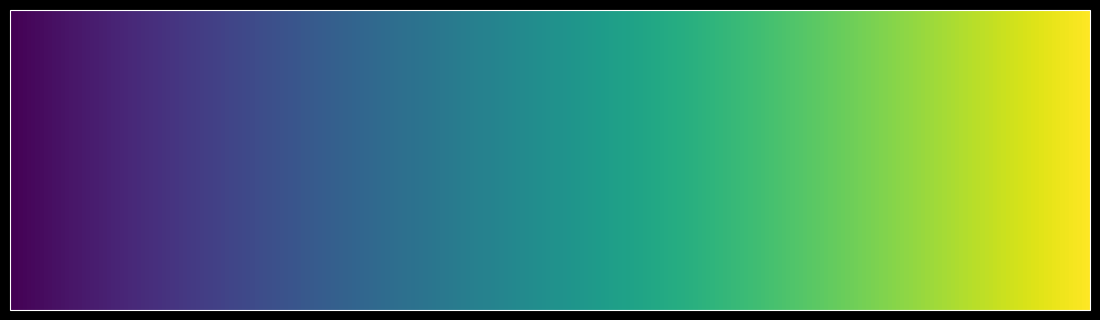

In [5]:
a = np.array([[0,1]])
pl.figure(figsize=(9, 1.5))
img = pl.imshow(a, cmap=pmap)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.1, 1.2, 2])
pl.colorbar(orientation="horizontal", cax=cax, ticks=[])
pl.savefig("images/colorbar.png")

pl.figure(figsize=(9, 1.5))
img = pl.imshow(a, cmap='viridis')
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.1, 1.2, 2])
pl.colorbar(orientation="horizontal", cax=cax, ticks=[])

## Functions

In [6]:
# Defines mode indices even about 0 for d dimensions
def ell(d):
    if d%2 == 0:
        l=np.linspace(-np.floor(d/2),np.floor(d/2),d+1,dtype=int)
        l=l[l != 0]
    else:
        l=np.linspace(-np.floor(d/2),np.floor(d/2),d,dtype=int)
    return l

#Phases for arbitrary MUBs in prime dimensions
def MUBphases(d,MUB):
    phi,p=[],[]
    for state in range(d):
        for j in range(d):
            p.append(((2*np.pi/d)*(MUB*(j**2)+state*j)))
        phi.append(p)
        p=[]
    return phi

#Mixing large amount of beams in a loop
def MixManyBeams(beams):
    if len(beams) > 1:
        beams[1]=BeamMix(beams[0],beams[1])
        beams.pop(0)
        MixManyBeams(beams)
    return beams[0]

#OAM beams 
def OAM(F, w0, state: int=0 ,phase=0,amp: float=1.0):
    F=GaussLaguerre(F, w0, p=0, l=state, A=amp*(1/w0)*np.sqrt(2/(np.pi*(math.factorial(abs(state))))), ecs=0)
    F=SubPhase(F,Phase(F)+phase)
    return F

#Arbitrary ANG mode in dimension d
def ANG(F,w0,d,state,norm=0):
    intensityNorm=[1,1,187.3568368182197,302.7415771427128,281.4774347094998,342.95046333063704,1,330.2491174614896,276.25225696328897,1,1,1,1,1,1,1,1,1,1,1,1,1]
    Q,p=[],[]
    l=ell(d)
    
    for i in range(d):
        p.append((2*np.pi/d)*i*state)

    for i in range(d):
        Q.append(OAM(F,w0,l[i],p[i]))

    F=MixManyBeams(Q)

    if norm==1:
        return [F,intensityNorm[d]]
    else:
        return F

#Arbitrary MUB in d dimensions {2,3,4,5,7,8}
def ArbMUB(F,w0,d,MUB,state,norm=0):
    intensityNorm=[1,1,187.3568368182197,302.7415771427128,281.4774347094998,342.95046333063704,1,330.2491174614896,276.25225696328897,1,1,1,1,1,1,1,1,1,1,1,1,1]
    Q,p=[],[]
    l=ell(d)
    if d==2:
        p=[[[0,0],[0,np.pi]],[[0,np.pi/2],[0,3*np.pi/2]]][MUB][state]
    elif d==4:
        p=[[[0,0,0,0],[0,np.pi,np.pi,0],[0,0,np.pi,np.pi],[0,np.pi,0,np.pi]],[[0,np.pi/2,np.pi/2,np.pi],[0,3*np.pi/2,3*np.pi/2,np.pi],[0,np.pi/2,3*np.pi/2,0],[0,3*np.pi/2,np.pi/2,0]],[[0,0,3*np.pi/2,np.pi/2],[0,np.pi,np.pi/2,np.pi/2],[0,0,np.pi/2,3*np.pi/2],[0,np.pi,3*np.pi/2,3*np.pi/2]],[[0,3*np.pi/2,0,np.pi/2],[0,np.pi/2,np.pi,np.pi/2],[0,np.pi/2,0,3*np.pi/2],[0,3*np.pi/2,np.pi,3*np.pi/2]]][MUB][state]
    elif d==8:
        p=[[[0,0,0,0,0,0,0,0],[0,np.pi/2,np.pi/2,np.pi,np.pi/2,np.pi,np.pi,3*np.pi/2],[0,np.pi/2,0,np.pi/2,0,3*np.pi/2,np.pi,np.pi/2],[0,0,np.pi/2,np.pi/2,np.pi/2,3*np.pi/2,0,np.pi],[0,0,np.pi/2,3*np.pi/2,0,np.pi,np.pi/2,np.pi/2],[0,np.pi/2,0,3*np.pi/2,np.pi/2,0,np.pi/2,np.pi],[0,np.pi/2,np.pi/2,0,0,np.pi/2,3*np.pi/2,np.pi],[0,0,0,np.pi,np.pi/2,np.pi/2,3*np.pi/2,np.pi/2]],[[0,np.pi,0,np.pi,0,np.pi,0,np.pi],[0,3*np.pi/2,np.pi/2,0,np.pi/2,0,np.pi,np.pi/2],[0,3*np.pi/2,0,3*np.pi/2,0,np.pi/2,np.pi,3*np.pi/2],[0,np.pi,np.pi/2,3*np.pi/2,np.pi/2,np.pi/2,0,0],[0,np.pi,np.pi/2,np.pi/2,0,0,np.pi/2,3*np.pi/2],[0,3*np.pi/2,0,np.pi/2,np.pi/2,np.pi,np.pi/2,0],[0,3*np.pi/2,np.pi/2,np.pi,0,3*np.pi/2,3*np.pi/2,0],[0,np.pi,0,0,np.pi/2,3*np.pi/2,3*np.pi/2,3*np.pi/2]],[[0,0,np.pi,np.pi,0,0,np.pi,np.pi],[0,np.pi/2,3*np.pi/2,0,np.pi/2,np.pi,0,np.pi/2],[0,np.pi/2,np.pi,3*np.pi/2,0,3*np.pi/2,0,3*np.pi/2],[0,0,3*np.pi/2,3*np.pi/2,np.pi/2,3*np.pi/2,np.pi,0],[0,0,3*np.pi/2,np.pi/2,0,np.pi,3*np.pi/2,3*np.pi/2],[0,np.pi/2,np.pi,np.pi/2,np.pi/2,0,3*np.pi/2,0],[0,np.pi/2,3*np.pi/2,np.pi,0,np.pi/2,np.pi/2,0],[0,0,np.pi,0,np.pi/2,np.pi/2,np.pi/2,3*np.pi/2]],[[0,np.pi,np.pi,0,0,np.pi,np.pi,0],[0,3*np.pi/2,3*np.pi/2,np.pi,np.pi/2,0,0,3*np.pi/2],[0,3*np.pi/2,np.pi,np.pi/2,0,np.pi/2,0,np.pi/2],[0,np.pi,3*np.pi/2,np.pi/2,np.pi/2,np.pi/2,np.pi,np.pi],[0,np.pi,3*np.pi/2,3*np.pi/2,0,0,3*np.pi/2,np.pi/2],[0,3*np.pi/2,np.pi,3*np.pi/2,np.pi/2,np.pi,3*np.pi/2,np.pi],[0,3*np.pi/2,3*np.pi/2,0,0,3*np.pi/2,np.pi/2,np.pi],[0,np.pi,np.pi,np.pi,np.pi/2,3*np.pi/2,np.pi/2,np.pi/2]],[[0,0,0,0,np.pi,np.pi,np.pi,np.pi],[0,np.pi/2,np.pi/2,np.pi,3*np.pi/2,0,0,np.pi/2],[0,np.pi/2,0,np.pi/2,np.pi,np.pi/2,0,3*np.pi/2],[0,0,np.pi/2,np.pi/2,3*np.pi/2,np.pi/2,np.pi,0],[0,0,np.pi/2,3*np.pi/2,np.pi,0,3*np.pi/2,3*np.pi/2],[0,np.pi/2,0,3*np.pi/2,3*np.pi/2,np.pi,3*np.pi/2,0],[0,np.pi/2,np.pi/2,0,np.pi,3*np.pi/2,np.pi/2,0],[0,0,0,np.pi,3*np.pi/2,3*np.pi/2,np.pi/2,3*np.pi/2]],[[0,np.pi,0,np.pi,np.pi,0,np.pi,0],[0,3*np.pi/2,np.pi/2,0,3*np.pi/2,np.pi,0,3*np.pi/2],[0,3*np.pi/2,0,3*np.pi/2,np.pi,3*np.pi/2,0,np.pi/2],[0,np.pi,np.pi/2,3*np.pi/2,3*np.pi/2,3*np.pi/2,np.pi,np.pi],[0,np.pi,np.pi/2,np.pi/2,np.pi,np.pi,3*np.pi/2,np.pi/2],[0,3*np.pi/2,0,np.pi/2,3*np.pi/2,0,3*np.pi/2,np.pi],[0,3*np.pi/2,np.pi/2,np.pi,np.pi,np.pi/2,np.pi/2,np.pi],[0,np.pi,0,0,3*np.pi/2,np.pi/2,np.pi/2,np.pi/2]],[[0,0,np.pi,np.pi,np.pi,np.pi,0,0],[0,np.pi/2,3*np.pi/2,0,3*np.pi/2,0,np.pi,3*np.pi/2],[0,np.pi/2,np.pi,3*np.pi/2,np.pi,np.pi/2,np.pi,np.pi/2],[0,0,3*np.pi/2,3*np.pi/2,3*np.pi/2,np.pi/2,0,np.pi],[0,0,3*np.pi/2,np.pi/2,np.pi,0,np.pi/2,np.pi/2],[0,np.pi/2,np.pi,np.pi/2,3*np.pi/2,np.pi,np.pi/2,np.pi],[0,np.pi/2,3*np.pi/2,np.pi,np.pi,3*np.pi/2,3*np.pi/2,np.pi],[0,0,np.pi,0,3*np.pi/2,3*np.pi/2,3*np.pi/2,np.pi/2]],[[0,np.pi,np.pi,0,np.pi,0,0,np.pi],[0,3*np.pi/2,3*np.pi/2,np.pi,3*np.pi/2,np.pi,np.pi,np.pi/2],[0,3*np.pi/2,np.pi,np.pi/2,np.pi,3*np.pi/2,np.pi,3*np.pi/2],[0,np.pi,3*np.pi/2,np.pi/2,3*np.pi/2,3*np.pi/2,0,0],[0,np.pi,3*np.pi/2,3*np.pi/2,np.pi,np.pi,np.pi/2,3*np.pi/2],[0,3*np.pi/2,np.pi,3*np.pi/2,3*np.pi/2,0,np.pi/2,0],[0,3*np.pi/2,3*np.pi/2,0,np.pi,np.pi/2,3*np.pi/2,0],[0,np.pi,np.pi,np.pi,3*np.pi/2,np.pi/2,3*np.pi/2,3*np.pi/2]]][state][MUB]
    else:
        for j in range(d):
            p.append(((2*np.pi/d)*(MUB*(j**2)+state*j)))
            
    for i in range(d):
        Q.append(OAM(F,w0,l[i],p[i]))
    F=MixManyBeams(Q)

    if norm==1:
        return [F,intensityNorm[d]]
    else:
        return F
    

### Generating Beam Plots

In [7]:
##These are custom functions for plotting the beams.
       
#Show a plot of the beam with phase and intensity
def plotBeamSingle(F,aperature=False,intensity=True,phase=True,filename=None,dpi=300):

    I=1-Intensity(1,F)
    Phi=np.mod(Phase(F),2*np.pi)

    fig=plt.figure(figsize=(5,5))
    ax = fig.add_subplot(121)

    ax.imshow(Phi,cmap=pmap,vmin=0,vmax=2*np.pi,interpolation='None') if phase==True else None
    ax.imshow(I,cmap=imap if phase==True else plt.colormaps['gray_r'], vmin=np.min(I),vmax=np.max(I),interpolation='None') if intensity == True else None

    if aperature!=False:
            N=F[0].N
            circle = plt.Circle((int(30*N/2), int(30*N/2)),30*N/2, color='w', fill=False)
            ax.add_patch(circle)
        
    plt.axis('off')
    plt.tight_layout()
    if filename!=None:
        plt.savefig(f'images/{filename}')


#Show a plot of an array of beams with phase and intensity
def plotBeamMulti(Fs,rows=1,aperature=False,intensity=True,phase=True,filename=None,dpi=300):
    fig = plt.figure(1,dpi=300)
    totalModes = len(Fs)
    if rows>=totalModes:
        columns=1
        rows=totalModes
    else:
        columns = totalModes//rows + (1 if totalModes%rows else 0)
    Position = range(1,totalModes + 1)

    for index,F in enumerate(Fs):
        I=1-Intensity(1,F)
        Phi=np.mod(Phase(F),2*np.pi)

        ax = fig.add_subplot(rows,columns,Position[index])

        ax.imshow(Phi,cmap=pmap,vmin=0,vmax=2*np.pi,interpolation='None') if phase==True else None
        ax.imshow(I,cmap=imap if phase==True else plt.colormaps['gray_r'] ,vmin=np.min(I),vmax=np.max(I),interpolation='None') if intensity ==True else None

        if aperature!=False:
            N=Fs[0].N
            circle = plt.Circle((int(30*N/2), int(30*N/2)),30*N/2, color='w', fill=False)
            ax.add_patch(circle)
        plt.axis('off')
        plt.tight_layout()
    if filename!=None:
        plt.savefig(f'images/{filename}')
    plt.show()


# Generic Plotting to Generate either single or multi-beam plots
def plotBeam(F,rows=1,aperature=False,intensity=True,phase=True,filename=None,dpi=300):
    if not hasattr(F, "__len__"):
        plotBeamSingle(F,aperature,intensity,phase,filename)
    else:
        plotBeamMulti(F,rows,aperature,intensity,phase,filename,dpi)
    

### Overlap integrals and crosstalk

In [8]:
#These are custom functions to calculate the overlap integral between two modes

# This is the overlap integral to check the fidelity between two modes
def overlapInt(F,G):
    F,G=Normal(F),Normal(G)
    Ffield,Gfield=np.conjugate(F.field),G.field
    fieldArr=np.multiply(Ffield,Gfield)
    summed=abs(np.sum(fieldArr))**2
    return summed

#Normalizes the overlap integrals for a tomographic measurement in dimension d. 
def normTomography(ints, d):
    return np.concatenate([
        chunk / chunk.sum() if chunk.sum() != 0 else chunk
        for chunk in np.split(ints, range(d, len(ints), d))
    ])

#Crosstalk of two vectors
def crosstalkVecs(Fs,Gs):
    c,C=[],[]
    for F in Fs:
        c=[]
        for G in Gs:
            c.append(abs(np.dot(np.conjugate(F),G))**2)
        C.append(c/sum(c))
    return C

#Calculate full crosstalk of two beam lists
def crosstalk(Fs,Gs):
    c,C=[],[]
    for F in Fs:
        c=[]
        for G in Gs:
            c.append(overlapInt(F,G))
        C.append(c/sum(c))
    return C

def tomography(Fs,Gs):
    c,C=[],[]
    for F in Fs:
        c=[]
        for G in Gs:
            c.append(overlapInt(F,G))
        C.append(normTomography(c,math.isqrt(len(Fs))))
    return C

def plotCrosstalk(cross):
    fig = plt.figure(1)
    plt.axis('off')
    plt.imshow(cross, interpolation='none', cmap='viridis', vmin=0,vmax=1)
    plt.show()

### Propagation

In [9]:
#Propagates one beam through the channel defined by the distance and the list of abberations that is input (abbs)
#If there are abberations, distance is the distance per abberation
def propChannel(F,distance,abbs=1,mode=0):
    if not hasattr(abbs, "__len__"):
        for i in range(abbs):
            if mode==1:
                F=Forvard(F,int(distance/abbs))
            elif mode == 2:
                F=Forward(F,int(distance/abbs),F.siz,F.N)
            else:
                F=Fresnel(F,int(distance/abbs))

    else:
        for screen in abbs:
            F=SubPhase(F,Phase(F)+screen)
            if mode==1:
                F=Forvard(F,int(distance/len(abbs)))
            elif mode == 2:
                F=Forward(F,int(distance/len(abbs)),F.size,F.N)
            else:
                F=Fresnel(F,int(distance/len(abbs)))
    return F

def propChannelSteps(F,distance,abbs=1):
    Fs=[]
    if not hasattr(abbs, "__len__"):
        for i in abbs:
            F=Forvard(F,int(distance/abbs))
            Fs.append(F)
            F=Forvard(F,distance)
    else:
        for screen in abbs:
            F=SubPhase(F,Phase(F)+screen)
            F=Forvard(F,int(distance/len(abbs)))
            Fs.append(F)
    return ([F,Fs])

### Parallelization

#### Parallelizing the propagation of all pixels

In [10]:
def worker_function(FieldIn,j, i, N, z, abbs):
    """
    Performs the calculation for a single (j, i) pair.

    Args:
        FieldIn: Initial field.
        j (int): Outer loop index.
        i (int): Inner loop index.
        N (int): Grid size.
        z (float): Propagation distance.

    Returns:
        tuple: (FieldOut, endField_data) for the specific (j, i)
    """
    # 1. Create the intensity matrix
    intens = np.zeros((N, N))
    intens[j][i] = 1

    #FieldOut = propChannel(SubIntensity(FieldIn, intens), z, abbs)
    FieldOut = propChannel(CircAperture(SubIntensity(FieldIn, intens),FieldIn.siz/2), z, abbs)
    #FieldOut = CircAperture(propChannel(CircAperture(SubPhase(SubIntensity(FieldIn, intens),np.zeros((N,N))),FieldIn.siz/2), z, abbs),FieldIn.siz/2)
    
    # 4. Extract data
    endField_data = np.array(FieldOut.field).reshape(N**2)

    return FieldOut,endField_data


def parallel_loop(FieldIn, N, z, abbs):
        
    # Initialize the results lists
    FieldsOut = []
    endFields_data = []
    
    max_workers = os.cpu_count()-2 or 4
    print(f"Starting parallel execution with {max_workers} processes...")

    tasks = [(j, i) for j in range(N) for i in range(N)]
    ...
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_to_task = {
            # Pass the raw data/args, NOT the complex FieldIn object
            executor.submit(worker_function, FieldIn, j, i, N, z, abbs): (j, i) 
            for j, i in tasks
        }
        
        # Iterate over the results as they complete, showing progress
        results_iterator = progress(
            as_completed(future_to_task), 
            total=len(tasks), 
            desc="Propagating invidual Pixels"
        )
        
        for future in results_iterator:
            try:
                # Get the result from the completed task
                FieldOut,endField_data = future.result()
                
                # Append the results to the main lists
                FieldsOut.append(FieldOut)
                endFields_data.append(endField_data)
                
            except Exception as exc:
                # Print any exceptions that occurred inside the worker function
                j, i = future_to_task[future]
                print(f'\n(j={j}, i={i}) generated an exception: {exc}')
                
    return FieldsOut,np.array(endFields_data)


# Channel Creation and Propagation

## Create Channel and Prop OAM

In [11]:
#Simulation Parameters
size = 30*cm
N=32   

#Beam Parameters
wavelength = 633*nm
w0=6.67/2*cm

#Propagataion Params
z=5000*m
numberOfPhaseScreens=1

#Turbulence Parameters
Turbulence=0.0000011
r0=size/Turbulence
abbs=[aotools.turbulence.phasescreen.ft_sh_phase_screen(r0,N,size/N,100,0.001) for i in range(numberOfPhaseScreens)]

100%|██████████| 10/10 [00:00<00:00, 1408.67it/s]


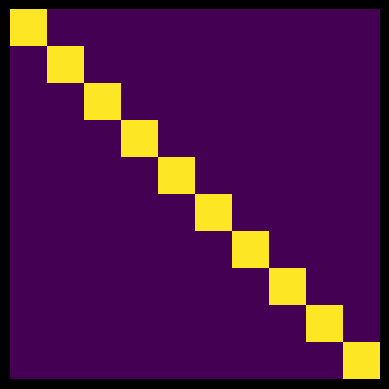

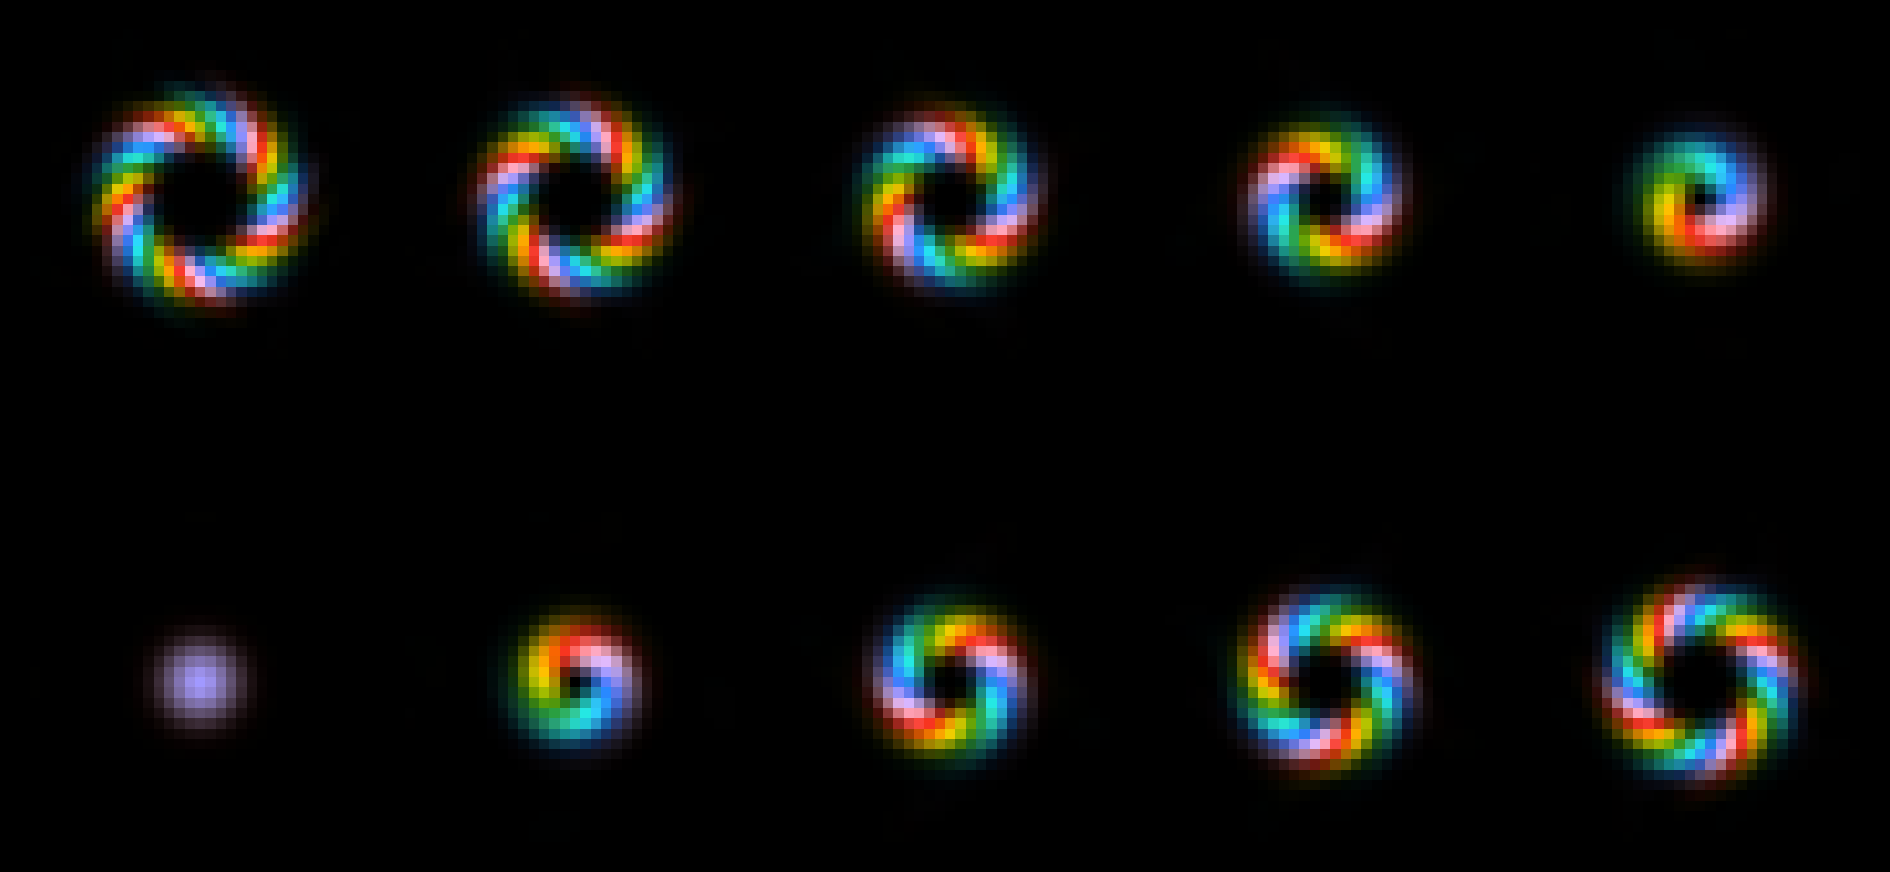

In [12]:
F=Begin(size,wavelength,N)

beams=[propChannel(OAM(F,w0,i),z,numberOfPhaseScreens,0) for i in progress(range(-5,5))]
errorBeams=[propChannel(OAM(F,w0,i),z,abbs,0) for i in progress(range(-5,5))]

plotCrosstalk(crosstalk(beams,errorBeams))
plotBeam(errorBeams,rows=2)
#plotBeam(errorBeams,rows=2,phase=False)
#plotBeam(errorBeams,rows=2,intensity=False)

## Propagate all Pixels

Starting parallel execution with 10 processes...


Propagating invidual Pixels: 100%|██████████| 1024/1024 [00:00<00:00, 4637.57it/s]


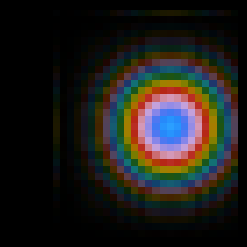

In [13]:
FieldsOut,endFields = parallel_loop(F,N, z, abbs)

assert len(endFields) == N**2

plotBeam(FieldsOut[int(N**2//2+np.sqrt(N**2//2))])

## Example Pixel OutPut

# Calculate EigenModes

In [14]:
transferMatrix=endFields.T
eigVals,eigVecs=np.linalg.eig(np.matmul(transferMatrix,np.conjugate(transferMatrix.T)))
#eigVals,eigVecs=np.linalg.eig(transferMatrix)

#Get the absolute values and phases of the eigenvalues
eigMags=abs(eigVals)

In [15]:
# Sort the Eigenvalues by the magnitudes
sort_indices = np.argsort(eigMags)[::-1]
eigMags = eigMags[sort_indices]
eigVals = eigVals[sort_indices]
eigVecs = eigVecs[:, sort_indices]

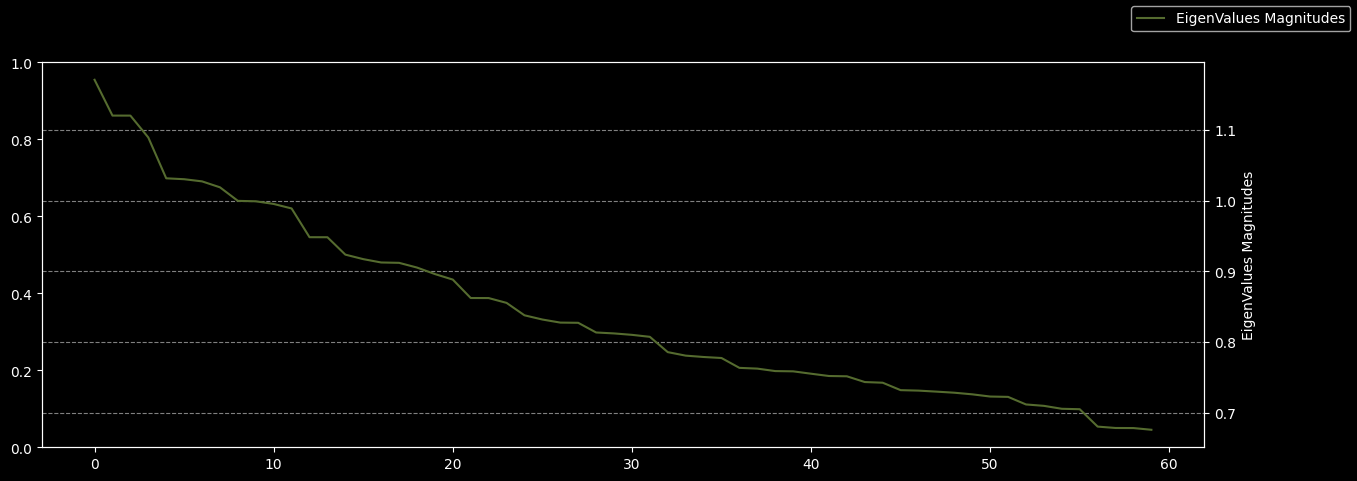

In [16]:
# Plot the eigenvalues

fig, ax1 = plt.subplots()
fig.set_size_inches(15,5)
x=range(0,len(eigMags))
ax2 = ax1.twinx()
ax2.yaxis.grid(True)
ax2.grid(visible=True,which='major',axis='both',color='gray',linestyle='--')
#ax1.set_ylabel('EigenValues Phases')
ax2.set_ylabel('EigenValues Magnitudes')

ax2.plot(x[:60],eigMags[:60],label='EigenValues Magnitudes',color='darkolivegreen')

fig.legend()
plt.show()

In [17]:
#Making Eigenvector optical modes
F=Begin(size,wavelength,N)
eigenBeams,propEigenBeams=[],[]
for i in progress(range(100)):
    mode=eigVecs[:,i]
    eigenInt=[abs(val)**2 for val in mode]
    eigenInt=np.pad(np.array(eigenInt).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    eigenPhase=[cmath.phase(val) for val in mode]
    eigenPhase=np.pad(np.array(eigenPhase).reshape((N,N)),pad_width=int(0), mode='constant', constant_values=0)
    F=SubPhase(SubIntensity(F,eigenInt),eigenPhase)
    eigenBeams.append(F)

100%|██████████| 100/100 [00:00<00:00, 1686.69it/s]


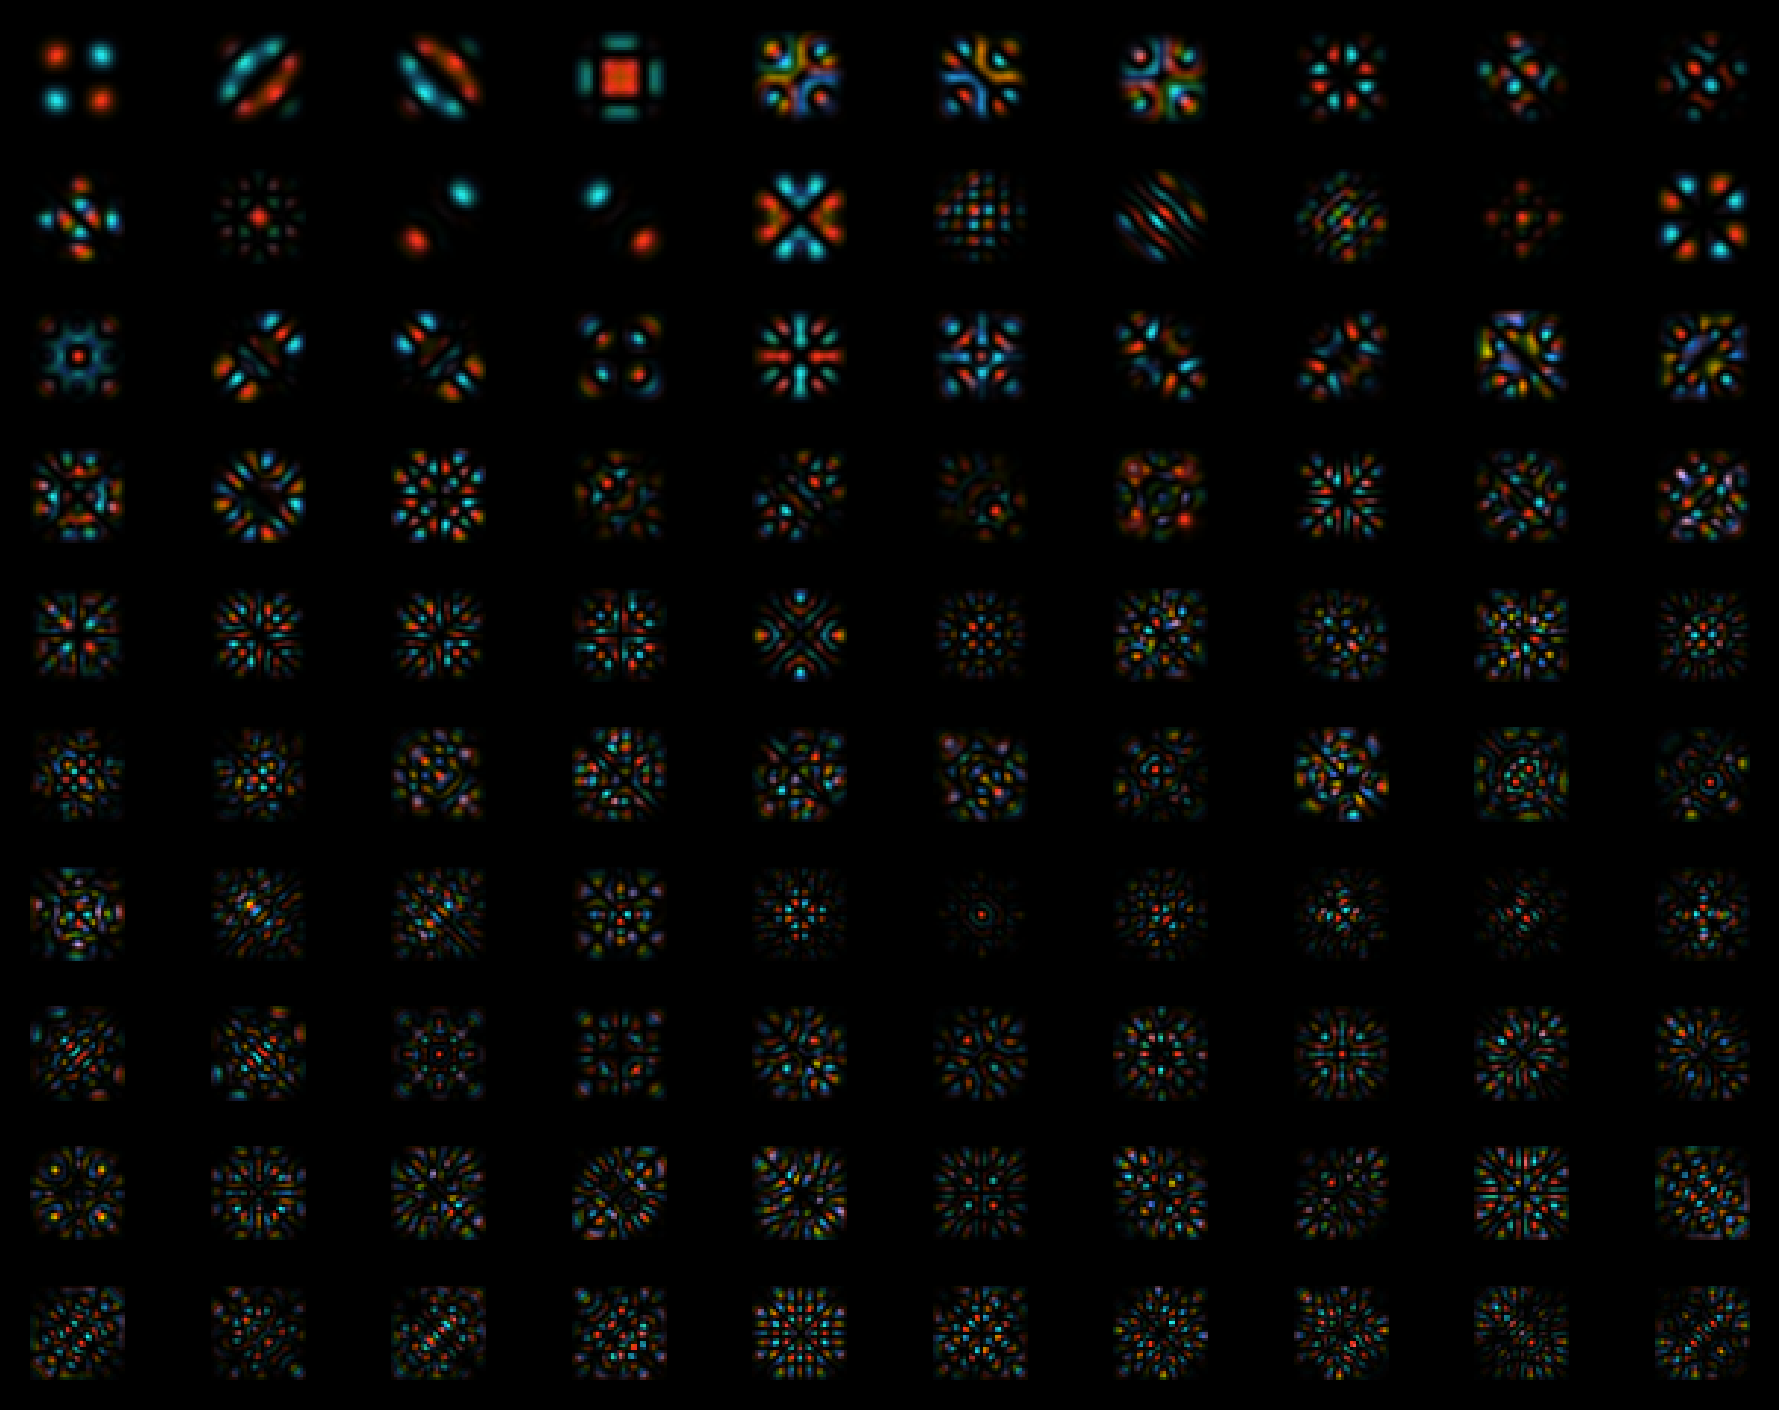

In [18]:
plotBeam(eigenBeams[:100],rows=10,dpi=1000)

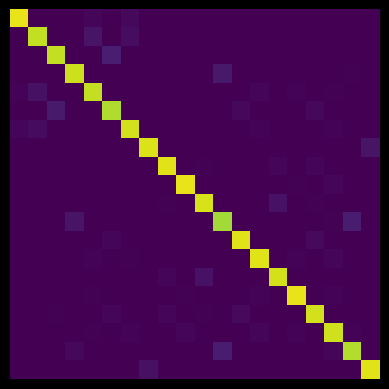

In [19]:
sorted_array = np.flip(np.argsort(eigMags)[-20:])
bestEigenModes=[eigenBeams[index] for index in sorted_array]
bestNoTurbEigenModesProp=[propChannel(eigenBeams[index],z,len(abbs),'0') for index in sorted_array]
bestEigenModesProp=[Normal(propChannel(eigenBeams[index],z,abbs,'0')) for index in sorted_array]
plotCrosstalk(crosstalk(bestEigenModes,bestEigenModesProp))